# **'The Simpsons' Image Classifier**

In [0]:
#To ensure that any edits to libraries are reloaded automatically and that any images displayed are shown in this notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
import zipfile
from google.colab import drive

#linking my drive account and unzipping the previously modified datasets from there
drive.mount('/content/drive/')
!unzip -q "/content/drive/My Drive/Colab Notebooks/Fast_AI/test_set_TSimp.zip" #test_set
!unzip -q "/content/drive/My Drive/Colab Notebooks/Fast_AI/training_val_set_TSimp.zip" #training_val_set

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [6]:
#every image has the label in the filename, so is necessary to extract those labels using regular expressions
path_img="/content/training_val_set"
fnames = get_image_files(path_img)
fnames[:20]

[PosixPath('/content/training_val_set/abraham_grampa_simpson_pic_0102.jpg'),
 PosixPath('/content/training_val_set/principal_skinner_pic_1017.jpg'),
 PosixPath('/content/training_val_set/milhouse_van_houten_pic_0353.jpg'),
 PosixPath('/content/training_val_set/homer_simpson_pic_0185.jpg'),
 PosixPath('/content/training_val_set/homer_simpson_pic_1484.jpg'),
 PosixPath('/content/training_val_set/milhouse_van_houten_pic_0768.jpg'),
 PosixPath('/content/training_val_set/homer_simpson_pic_1073.jpg'),
 PosixPath('/content/training_val_set/homer_simpson_pic_0828.jpg'),
 PosixPath('/content/training_val_set/homer_simpson_pic_1735.jpg'),
 PosixPath('/content/training_val_set/apu_nahasapeemapetilon_pic_0146.jpg'),
 PosixPath('/content/training_val_set/charles_montgomery_burns_pic_0026.jpg'),
 PosixPath('/content/training_val_set/krusty_the_clown_pic_0411.jpg'),
 PosixPath('/content/training_val_set/chief_wiggum_pic_0445.jpg'),
 PosixPath('/content/training_val_set/moe_szyslak_pic_0414.jpg'),
 Po

In [0]:
np.random.seed(100)
bs = 64 #could be smaller if there is a memory error
pat = r'/([^/]+)_pic_\d+.jpg$' #regexp
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

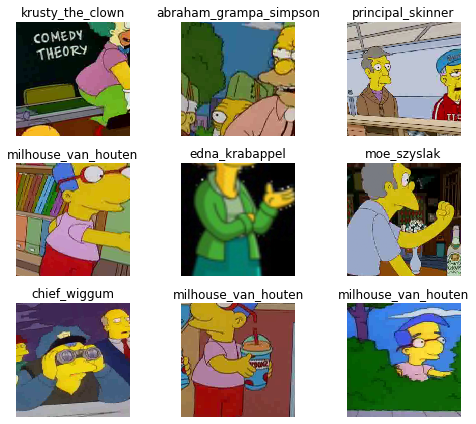

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes) #character labels 
len(data.classes) #number of distinct categories

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


42

**Training with resnet34**

Using a CNN backbone and a fully connected head with a single hidden layer as a classifier. Model takes images as input and the output is the **predicted** probability for each of the 42 categories.

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [11]:
learn.fit_one_cycle(4) #with 4 epochs


epoch,train_loss,valid_loss,error_rate,time
0,1.508034,0.721133,0.193024,04:07
1,0.788715,0.437563,0.123985,04:10
2,0.582051,0.330662,0.088151,04:09
3,0.429816,0.311414,0.081462,04:12


In [0]:
learn.save('model1')


**Results**

In [13]:
interp = ClassificationInterpretation.from_learner(learn) #to see which were the categories that the model most confused with one another
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

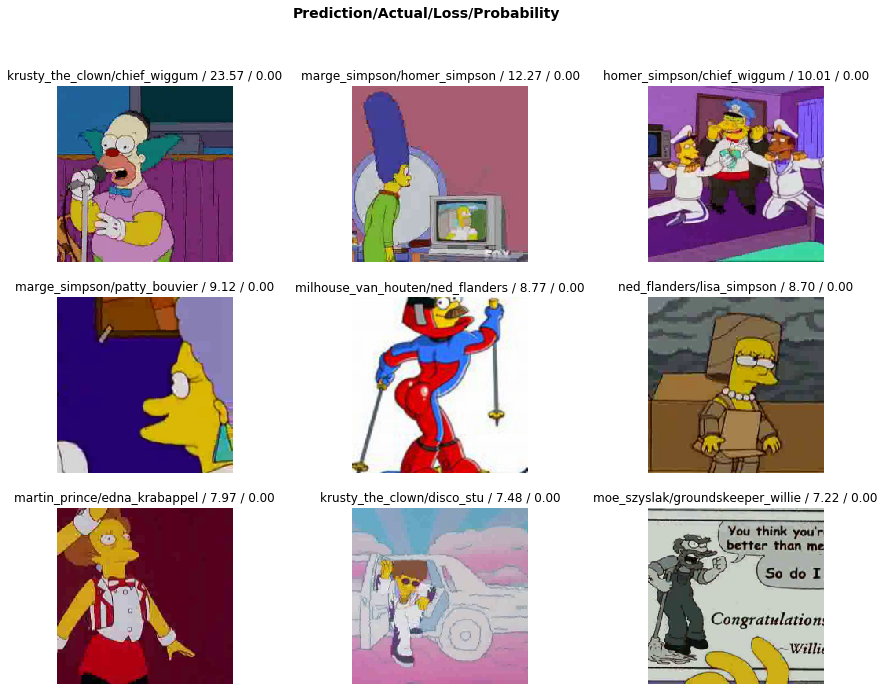

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

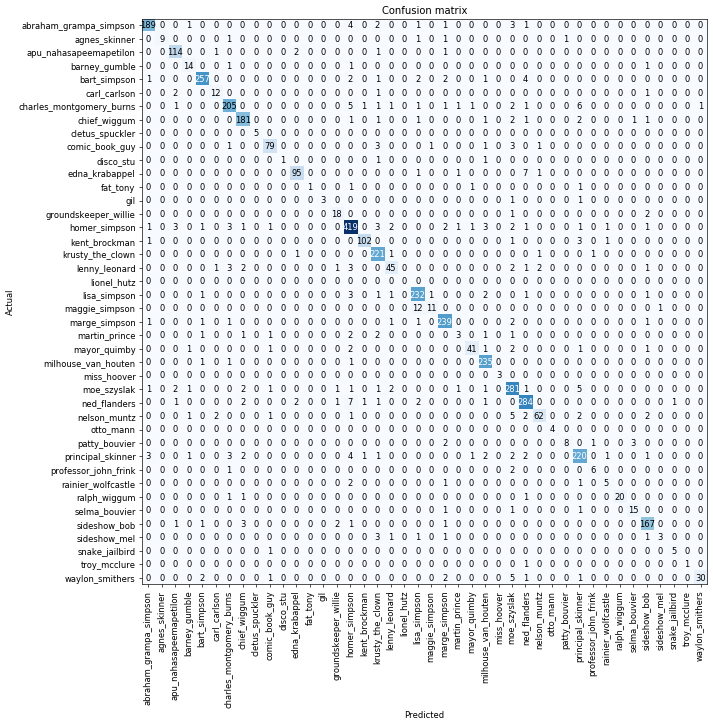

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=5)

[('maggie_simpson', 'lisa_simpson', 12),
 ('edna_krabappel', 'ned_flanders', 7),
 ('ned_flanders', 'homer_simpson', 7),
 ('charles_montgomery_burns', 'principal_skinner', 6),
 ('charles_montgomery_burns', 'homer_simpson', 5),
 ('moe_szyslak', 'principal_skinner', 5),
 ('nelson_muntz', 'moe_szyslak', 5),
 ('waylon_smithers', 'moe_szyslak', 5)]

In [0]:
learn.load('model1');

In [0]:
learn.lr_find()

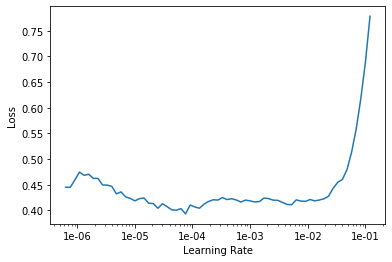

In [23]:
learn.recorder.plot()

**Fine Tuning**

In [24]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.357721,0.212295,0.060201,04:18
1,0.270121,0.176035,0.048256,04:11
